In [198]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [199]:
import datetime
import re
import requests
import pandas
import inflection
import numpy

In [200]:
from sklearn.linear_model import LinearRegression

In [201]:
import quandl
quandl.ApiConfig.api_key = '7dMDm25fMpxGZr_cxdXe'
quandl.ApiConfig.api_version = '2015-04-09'

In [202]:
pandas.set_option('max_columns', None)
pandas.set_option('max_rows', None)

In [203]:
DATE_FORMAT = '%Y-%m-%d'  # using NYT's format

In [204]:
# prices of SPX futures
df_spx = quandl.get('CHRIS/CME_SP1').reset_index()
df_spx = df_spx[df_spx['Date'] >= '2015-01-01'].reset_index(drop=True)
df_spx.rename(columns={'Date':'date', 'Last':'spx'}, inplace=True)
df_spx['date'] = df_spx['date'].dt.strftime(DATE_FORMAT)
df_spx.drop([col for col in df_spx.columns if col not in ('date','spx')], axis=1, inplace=True)

In [206]:
def convert_american_odds_to_prob(american_odds):
    if american_odds > 100:
        return 100 / (100 + american_odds)
    else:
        return (-1 * american_odds) / (100 - american_odds)

In [211]:
## Get the current market value from pinny
pinny_json = requests.get('https://www.pinnacle.com/webapi/1.15/api/v1/GuestLines/Contest/Politics/2016-Presidential-Election-USA').json()
pinny_list = pinny_json['Leagues'][0]['Events'][0]['Participants']
pinny_offer_dict = {el['Name']: convert_american_odds_to_prob(el['MoneyLine']) for el in pinny_list}

pinny_trump_offer = pinny_offer_dict['Donald Trump and all others']
pinny_clinton_offer = pinny_offer_dict['Hillary Clinton']

pinny_clinton_bid = 1 - pinny_trump_offer
pinny_trump_bid = 1 - pinny_clinton_offer

In [212]:
# set fair values to pinny mid-market
# alternatively you could set these things to any probability
CLINTON_FAIR = (pinny_clinton_bid + pinny_clinton_offer) / 2
TRUMP_FAIR   = (pinny_trump_bid + pinny_trump_offer) / 2

In [213]:
pinny_clinton_bid, pinny_clinton_offer

(0.7975708502024291, 0.8266897746967071)

In [14]:
## Fetch 538 predictions and load into pandas.DataFrame
data_538 = requests.get('http://projects.fivethirtyeight.com/2016-election-forecast/updates.json').json()
list_538 = []

for model_538 in data_538['updates'][::-1]:
    dt = datetime.datetime.fromtimestamp(model_538['added'])
    
    trump_append = {
        'candidate': 'Trump',
        'date': dt.strftime(DATE_FORMAT),
        'datetime': dt,
    }
    
    
    clinton_append = {
        'candidate': 'Clinton',
        'date': dt.strftime(DATE_FORMAT),
        'datetime': dt,
    }
    
    for model, candidate_list in model_538['diffs'].items():
        for candidate in candidate_list:
            
            model_forecast = float(candidate['winprob']['current'])
            forecast_iden = inflection.underscore('538__{model}'.format(model=model))
            
            if candidate['candidate'] == 'Trump':
                trump_append[forecast_iden] = model_forecast
            elif candidate['candidate'] == 'Clinton':
                clinton_append[forecast_iden] = model_forecast
    
    list_538.append(clinton_append)
    list_538.append(trump_append)

order_538 = ['candidate','date','datetime','538__now_cast','538__polls_only','538__polls_plus']
df_538 = pandas.DataFrame(list_538)[order_538].reset_index(drop=True)
df_538.sort_values('datetime', inplace=True)
df_538.drop(['datetime'], axis=1, inplace=True)

In [15]:
# Fetch PredictWise data & load into pandas.DataFrame
data_pw = requests.get('http://table-cache1.predictwise.com/history/table_1523.json').json()
list_pw = []
dt_index_pw = []

for pw_history in data_pw['history']:
    dt = datetime.datetime.strptime(pw_history['timestamp'], '%m-%d-%Y %I:%M%p')
    
    clinton_append = {
        'candidate': 'Clinton',
        'date': dt.strftime(DATE_FORMAT),
        'datetime': dt,
    }
    trump_append = {
        'candidate': 'Trump',
        'date': dt.strftime(DATE_FORMAT),
        'datetime': dt,
    }
    
    for pw_table in pw_history['table']:
        party = pw_table[0]
        
        pw_data = {}
        for column, value in zip(data_pw['header'][1:], pw_table[1:]):
            col_name = 'pw__{c}'.format(c=inflection.underscore(column)).replace(' ','_')
            pw_data[col_name] = float(re.sub(r'\$|,|\%','',str(value)))
        
        ## convert pw__predict_wise to proba (currently a percent)
        pw_data['pw__predict_wise'] = pw_data['pw__predict_wise'] / 100
        
        if party == 'Democratic':
            clinton_append.update(pw_data)
        elif party == 'Republican':
            trump_append.update(pw_data)
    
    list_pw.append(clinton_append)
    list_pw.append(trump_append)

df_pw = pandas.DataFrame(list_pw)
df_pw.sort_values('datetime', inplace=True)
df_pw.drop(['datetime'], axis=1, inplace=True)

In [16]:
## Ignore HuffPo for now: they're polls not predictions
# df_huffpo = pandas.read_csv('http://elections.huffingtonpost.com/pollster/2016-general-election-trump-vs-clinton.csv')

In [17]:
# Fetch NYT predictions and load into pandas.DataFrame
raw_df_nyt = pandas.read_csv('https://static01.nyt.com/newsgraphics/2016/08/05/presidential-forecast/54c9e640a5c8d15d126d86480a2245bded598d0c/timeseries.csv')
nyt_list = []
for date_record in raw_df_nyt.to_dict(orient='records'):
    nyt_list.append({
            'date': date_record['date'],
            'candidate': 'Clinton',
            'nyt': date_record['dem']
        })
    nyt_list.append({
            'date': date_record['date'],
            'candidate': 'Trump',
            'nyt': date_record['rep']
        })

df_nyt = pandas.DataFrame(nyt_list)

In [18]:
## Look at the latest forecast made on each date
gb_538 = df_538.groupby(['date', 'candidate'], as_index=False).nth(-1)
gb_pw = df_pw.groupby(['date', 'candidate'], as_index=False).nth(-1)

In [26]:
## Merge to one big DataFrame
df = pandas.merge(gb_538, gb_pw, how='outer').merge(df_nyt, how='outer').merge(df_spx, on='date', how='left')
df.sort_values('date', inplace=True)
df.reset_index(inplace=True, drop=True)
df['fair_value'] = df['candidate'].apply(lambda k: TRUMP_FAIR if k == 'Trump' else CLINTON_FAIR)

In [189]:
clinton_df = df[(df['candidate']=='Clinton') & (df['date'] > '2016-01-01')][['date','spx','pw__betfair']]

In [190]:
clinton_df['lr_spx'] = numpy.log(clinton_df['spx']) - numpy.log(clinton_df['spx'].shift(1))
clinton_df['betfair_diff'] = numpy.log(clinton_df['pw__betfair']) - numpy.log(clinton_df['pw__betfair'].shift(1))


# clinton_df['betfair_diff'] = -numpy.log(1/clinton_df['pw__betfair'] - 1) - -numpy.log(1/clinton_df['pw__betfair'].shift(1) - 1)

In [191]:
clinton_df = clinton_df.dropna().reset_index(drop=True)

In [192]:
lm = LinearRegression()

In [193]:
lm.fit(y=clinton_df['betfair_diff'], X=clinton_df[['lr_spx']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [194]:
lm.coef_, lm.intercept_

(array([ 0.1698375]), -0.00034857107492276097)

In [195]:
numpy.corrcoef(clinton_df['lr_spx'], clinton_df['betfair_diff'])

array([[ 1.        ,  0.08624086],
       [ 0.08624086,  1.        ]])

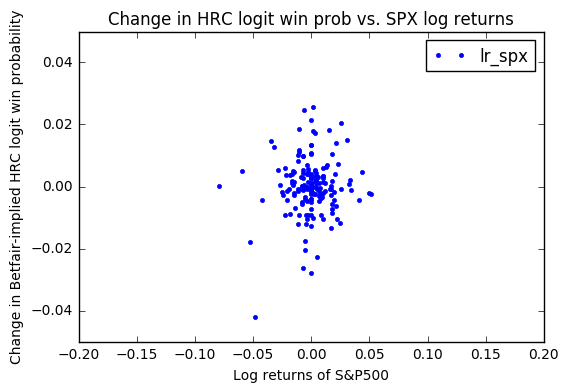

In [196]:
ax = clinton_df.plot(x='betfair_diff', y='lr_spx', style='.', xlim=(-0.2, 0.2), ylim=(-0.05, 0.05))
ax.set_xlabel("Log returns of S&P500")
ax.set_ylabel("Change in Betfair-implied HRC logit win probability")
ax.set_title("Change in HRC logit win prob vs. SPX log returns")

In [197]:
## don't really know where i want to take this from here
## really like your kelly betting method of PnLing
## so might implement that in Python

In [33]:
def loss_function(truth_series, predict_series):
    return (truth_series * numpy.log(predict_series)).mean()

In [528]:
to_compare = [
    'nyt',
    'pw__predict_wise',
    'pw__predict_it',
    'pw__iem',
    'pw__hypermind',
    'pw__betfair',
    '538__now_cast',
    '538__polls_only',
    '538__polls_plus'
]

In [529]:
comparisons = []
for compare_column in to_compare:
    compare_df = df[pandas.notnull(df[compare_column])]
    
    y_true = (compare_df['fair_value'])
    y_pred = (compare_df[compare_column])
    
    loss = loss_function(y_true, y_pred)
    
    comparisons.append({
            'prediction': compare_column,
            'loss': loss,
        })
comparisons_df = pandas.DataFrame(comparisons)[['prediction','loss']]
comparisons_df.sort_values('loss', ascending=False, inplace=True)
comparisons_df.reset_index(inplace=True, drop=True)

In [530]:
comparisons_df

,prediction,loss
0,nyt,-0.237565
1,538__polls_only,-0.251104
2,pw__predict_wise,-0.252528
3,538__polls_plus,-0.253090
4,538__now_cast,-0.253106
5,pw__predict_it,-0.255152
6,pw__betfair,-0.255438
7,pw__iem,-0.255601
8,pw__hypermind,-0.265053
